<a href="https://colab.research.google.com/github/Moojin-Bin/Gaussian_Mixture_Models_for_Finance/blob/master/GMM_for_Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

an Application of Gaussian Mixture Models for Financial Markets

First of all, import packages as usual.

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from sklearn import mixture
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import rcParams, cycler, gridspec

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


To use mixture model of scikit-learn, we need to extract values from dataframe and change the format to array.

In [7]:
def df_to_array(df):
    array = np.ravel(df.dropna()).astype(np.float).reshape(-1, 1)
    return array

Here, you can decide to use a logarithm or not. According to my experience, using logarithm returns the better results if data has always positive values.

In [4]:
def plot_best_fit_mixture(df, max_n_components, log = True):
    
    if log == True:
        X = df_to_array(np.log(df))
    elif log == False:
        X = df_to_array(df)
    
    N = np.arange(1, max_n_components+1)
    models = [None]*max_n_components

    for i in range(max_n_components):
        models[i] = mixture.GaussianMixture(N[i], n_init = 10).fit(X)

    AIC = [m.aic(X) for m in models]
    BIC = [m.bic(X) for m in models]
    M_best = models[min(np.argmin(AIC), np.argmin(BIC))]

    fig = plt.figure(figsize = (12, 4))
    fig.subplots_adjust(wspace=0.3)

    # plot 1: Information Critetion
    ax1 = fig.add_subplot(131)
    ax1.plot(N, AIC, '-k', label = 'AIC')
    ax1.plot(N, BIC, '--k', label = 'BIC')
    ax1.set_title('Theoretical Information Criterion')
    ax1.set_xlabel('n. components')
    ax1.set_ylabel('information criterion')
    ax1.legend()


    # plot 2: Histogram and best-fit mixture
    ax2 = fig.add_subplot(132)

    x_min = X.min() - 0.2
    x_max = X.max() + 0.2
    x = np.linspace(x_min, x_max, 1000)
    logprob = M_best.score_samples(x.reshape(-1, 1))    # Compute the weighted log probabilities for each sample.
    responsibilities = M_best.predict_proba(x.reshape(-1, 1))    # Predict posterior probability of each component given the data.
    pdf = np.exp(logprob)    # probability density function, it can be greater than 1
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    ax2.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
    ax2.plot(x, pdf, '-k')
    ax2.plot(x, pdf_individual, '--k')
    ax2.set_title("Best-fit Mixture")
    if log == True:
        ax2.set_xlabel('$log(x)$')
    else:
        ax2.set_xlabel('$x$')
    ax2.set_ylabel('$p(x)$')


    # plot 3: Posterior probabilities for each component
    ax3 = fig.add_subplot(133)

    best_fit_n_components = M_best.n_components
    p = responsibilities
    p = p.cumsum(1).T

    for i in range(best_fit_n_components):
        if i == 0:
            ax3.fill_between(x, 0, p[i], color='gray', alpha = 1/best_fit_n_components)
        else:
            ax3.fill_between(x, p[i-1], p[i], color='gray', alpha = (1+i)/best_fit_n_components)
    ax3.set_xlim(x_min, x_max)
    ax3.set_ylim(0, 1)
    ax3.set_title('Posterior Probabilities')
    if log == True:
        ax3.set_xlabel('$log(x)$')
    else:
        ax3.set_xlabel('$x$')
    ax3.set_ylabel(r'$p({\rm class}|x)$')

In [5]:
def GMM(df, n_components, log=True):
    
    if log == True:
        X = df_to_array(np.log(df).fillna(method='ffill'))
    else:
        X = df_to_array(df.fillna(method='ffill'))

    gmm = mixture.GaussianMixture(n_components, n_init= 10)
    gmm.fit(X)

    hidden_states = gmm.predict(X)
    hidden_states_prob = gmm.predict_proba(X)

    stat = {}
    z = {}

    for i in range(n_components):
        mask = hidden_states == i
        z['Regime_%d' %i] = pd.DataFrame(X[mask], index = df.index[mask], columns = ['Regime_%d' %i])
        z['Regime_%d' %i] = z['Regime_%d' %i].reindex(df.index, fill_value=np.nan)
        stat['Regime_%d' %i] = pd.DataFrame.describe(z['Regime_%d' %i]).loc[['min', 'mean', 'max']]

    stats = pd.concat([stat[key] for key in stat.keys()], axis=1)
    hsp = pd.DataFrame(hidden_states_prob, index=df.index, columns = z.keys())    # Hidden States Probability

    regimes = list(z.keys())
    gmm_res = pd.DataFrame([])
    for i in range(n_components):
        gmm_res = pd.concat([gmm_res, z[regimes[i]]], axis=1)

    # Sort Regime order
    stats.sort_values(by='mean', axis=1, inplace = True)
    new_regime = stats.columns

    gmm_res = gmm_res[new_regime]
    hsp = hsp[new_regime]

    new_regime_columns = list('Regime: %d' %(i+1) for i in range(n_components))

    gmm_res.columns = new_regime_columns
    stats.columns = new_regime_columns
    hsp.columns = new_regime_columns

    if log == True:
        gmm_res = np.exp(gmm_res)
        stats = np.exp(gmm_res)
    else:
        pass

    cmap = cm.get_cmap('RdYlGn_r')
    rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, len(regimes))))

    # Plotting results
    fig = plt.figure(figsize = (8, 6))
    fig.subplots_adjust(hspace=0.3)
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[2,1])

    # plot 1: Information Critetion
    ax1 = fig.add_subplot(gs[0])
    x1 = gmm_res.index
    y1 = gmm_res.values
    labs1 = list(gmm_res.columns)
    ax1.plot(x1, y1)
    ax1.legend(labs1)
    ax1.set_title('Historical Level')
    
    # plot 2: Stacked Plot of Hidden States Probabilities
    x = hsp.index
    y = hsp.values.T
    labs = list(hsp.columns)

    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.stackplot(x, y, labels=labs, alpha = 0.8)
    ax2.set_title('Porterior Probability')

    return gmm_res, stats, hsp

Now, let's get started with an example of CBOE S&P 500 Volatility Index(hereinafter referred to as VIX). 
Note that because VIX has always positive values, we may use the logarithm of VIX to figure out the status of VIX. 

In [6]:
df = pdr.DataReader('VIXCLS', "fred", '19700101')

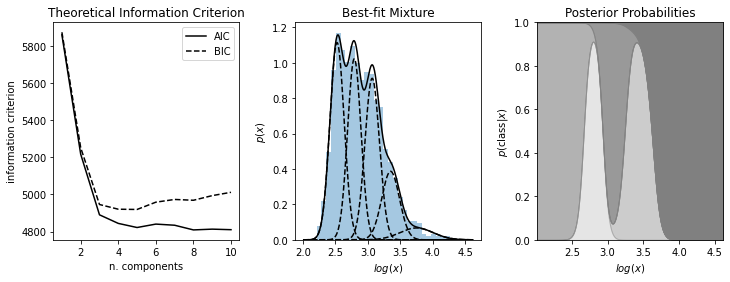

In [8]:
plot_best_fit_mixture(df, 10, True)

Here, we figured out that the number of components we need is 5. 

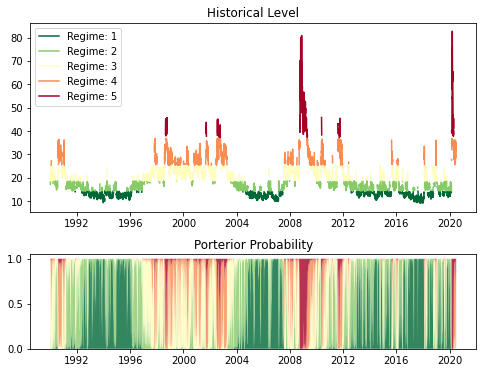

In [9]:
gmm_res, stats, hsp = GMM(df, 5, True)